In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn import linear_model
pd.set_option("display.max_rows",140)
from sklearn.metrics import r2_score
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
import wikipedia
import random
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
pd.set_option('display.width', 2000) 
pd.set_option ('display.max_columns' , 2000)
pd.set_option("display.max_rows", 2000)


In [3]:
def comply_good_df (Model, x_data , y_data, cv, show_elim_features = False):
    Inner_skf = StratifiedKFold(n_splits= cv, random_state= 17)
    features = x_data.columns.tolist()
    complied_df = pd.DataFrame()
    best_temp_score = 0
    best_gen_score = 0
    for iter in range(x_data.shape[1]):
        for feature in features:
            temp_df = complied_df.copy()
            temp_df[feature] = x_data[feature]
            feature_scores = cross_val_score(Model, temp_df, y_data, cv = Inner_skf,
                                             scoring= 'r2', n_jobs= -1)
            mean_score_with_feature =  feature_scores.mean()
            if mean_score_with_feature > best_temp_score:
                best_temp_score = mean_score_with_feature
                best_feature = feature
        if best_temp_score > best_gen_score:
            complied_df[best_feature] = x_data[best_feature]
            features.remove(best_feature)
            best_gen_score = best_temp_score
        else:
            break
    elim_features = list(set(x_data.columns) - set(complied_df.columns))
    if show_elim_features:
        return complied_df, elim_features
    else:
        return complied_df

In [4]:
def add_model_output (Model, x_data, y_data, num_cross_val = 5, add_feature = True):
    x_data = x_data.copy()
    import warnings
    warnings.filterwarnings('ignore')
    Inner_SKF = StratifiedKFold(n_splits=  num_cross_val, shuffle= True, random_state= 17)
    Model_outputs = pd.Series(np.zeros(x_data.shape[0]))
    for train_df_id , apply_df_id in Inner_SKF.split(x_data, y_data):
        train_df_x = x_data.iloc[train_df_id, :]
        train_df_Y = y_data[train_df_id]
        apply_df = x_data.iloc[apply_df_id, :]
        Model.fit(train_df_x, train_df_Y)
        out_put = pd.Series(Model.predict(apply_df))
        Model_outputs[apply_df_id] = out_put
    if add_feature:
        x_data[str(Model).split('(')[0]] = Model_outputs
        return x_data
    else:
        return Model_outputs

In [5]:
def tree_features (x_data, y_data, deep = 3,add_features = False, use_each_column = False, deep_each_col = 1):
    x_data = x_data.copy()
    List_features = x_data.columns.tolist()
    Tree_features = pd.DataFrame()
    if use_each_column:
        Tree = DecisionTreeRegressor(max_depth= deep_each_col, random_state= 17)
        for feature in ['Avg ° C', 'Millimetres','SUN Total Hours', 'SUN Clear Days', 'Humidity State']:
            Tree.fit(np.array(x_data[feature]).reshape(-1, 1), y_data)
            Threshold = Tree.tree_.threshold.tolist()
            for Thresh in Threshold:
                if Thresh == -2:
                    continue
                else:
                    if add_features:
                        x_data[feature+ ' '+ '<=' + ' '+str(Thresh)] = x_data[feature].apply(lambda x:int(x <= Thresh))
                    else:
                        Tree_features[feature+ ' '+ '<=' + ' '+str(Thresh)] = x_data[feature].apply(lambda x:int(x <= Thresh))
        if add_features:
            return x_data
        else:
            return  Tree_features
    else:
        Tree = DecisionTreeRegressor(max_depth= deep, random_state= 17)
        Tree.fit(x_data, y_data)
        Features = Tree.tree_.feature.tolist()
        Threshold = Tree.tree_.threshold.tolist()
        for Thresh, Feature in [*zip(Threshold, Features)]:
            if Thresh == -2 and Feature ==  -2:
                continue
            else:
                if add_features:
                    Col = List_features[Feature]
                    x_data[Col+ ' '+ '<=' + ' '+str(Thresh)] = x_data[Col].apply(lambda x:int(x <= Thresh))
                else:
                    Col = List_features[Feature]
                    Tree_features[Col+ ' '+ '<=' + ' '+str(Thresh)] = x_data[Col].apply(lambda x:int(x <= Thresh))
        if add_features:
            return x_data
        else:
            return  Tree_features

In [6]:
def apply_tree_features_to_test (features, test):
    test = test.copy()
    features_ = [*map(lambda x: (x.split('<=')[0].rstrip(),float(x.split('<=')[1])),features)]
    pos = 0
    for col, thresh in features_:
        test[features[pos]] = test[col].apply(lambda x: int(x <= thresh))
        pos += 1
    return test

In [7]:
def tree_features_on_cv (Model, x_data, y_data, scoring = 'roc_auc', num_cv = 5, 
                         shuffle = True, deep_tree = 1, use_each_column = False, deep_each_col = 1):
    x_data = x_data.copy()
    Inner_SKF = StratifiedKFold(random_state= 17, n_splits=num_cv, shuffle = shuffle)
    scores = []
    for train_df_id, apply_df_id in Inner_SKF.split(x_data, y_data):
        train_df_x = x_data.iloc[train_df_id, :]
        train_df_y = y_data[train_df_id]
        apply_df_x = x_data.iloc[apply_df_id, :]
        apply_df_y = y_data[apply_df_id]
        train_df_x_tree = tree_features(train_df_x, 
                                        train_df_y,
                                        use_each_column= use_each_column, 
                                        deep_each_col= deep_each_col,
                                        deep= deep_tree,
                                        add_features=True)
        Model.fit(train_df_x_tree, train_df_y)
        Features = (tree_features(train_df_x, 
                                        train_df_y,
                                        use_each_column= use_each_column, 
                                        deep = deep_tree,
                                        deep_each_col= deep_each_col,
                                        add_features = False)).columns
        apply_df_x_treee = apply_tree_features_to_test(Features, apply_df_x)
        if scoring == 'r2':
            Y_pred = Model.predict(apply_df_x_treee)
            r_2 = r2_score(Y_pred, apply_df_y)
            scores.append(r_2)
        elif scoring == 'roc_auc':
            Y_pred = Model.predict_proba(apply_df_x_treee)
            roc_auc = roc_auc_score(Y_pred, apply_df_y)
            scores.append(roc_auc)
    return np.array(scores)

In [8]:
def model_out_put_on_cv (Model, x_data, y_data, num_cv = 5, num_cv_model = 5,  shuffle = True, scoring = 'roc_auc'):
    x_data = x_data.copy()
    Inner_SKF = StratifiedKFold(random_state= 17, n_splits=num_cv, shuffle = shuffle)
    warnings.filterwarnings('ignore')
    scores = []
    mean_inner_scores = []
    for train_id, test_id in Inner_SKF.split(x_data, y_data):
        x_train = x_data.iloc[train_id,:]
        x_train.index = np.arange(x_train.shape[0])
        y_train = y_data[train_id]
        y_train.index = np.arange(x_train.shape[0])
        x_test = x_data.iloc[test_id,:]
        x_test.index = np.arange(x_test.shape[0])
        y_test = y_data[test_id]
        y_test.index = np.arange(x_test.shape[0])
        x_train_model_out_put = add_model_output(Model, x_train,  y_train, num_cross_val= num_cv_model, add_feature= True)
        if scoring == 'roc_auc':
            Inner_scores = cross_val_score(Model,
                                           x_train_model_out_put,
                                           y_train,
                                           n_jobs= -1, 
                                           cv= Inner_SKF, 
                                           scoring='roc_auc')
            Mean_cv = Inner_scores.mean()
            mean_inner_scores.append(Mean_cv)
            Model.fit(x_train ,y_train)
            x_test['Model_output'] = Model.predict_proba(x_test)
            Model.fit(x_train_model_out_put, y_train)
            Predicted_val = Model.predict_proba(x_test)
            roc_auc = roc_auc_score(Predicted_val, y_test)
            scores.append(roc_auc)
        elif scoring == 'r2':
            Inner_scores = cross_val_score(Model,
                                           x_train_model_out_put,
                                           y_train,
                                           n_jobs= -1, 
                                           cv= Inner_SKF, 
                                           scoring='r2')
            Mean_cv = Inner_scores.mean()
            mean_inner_scores.append(Mean_cv)
            Model.fit(x_train ,y_train)
            x_test['Model_output'] = Model.predict(x_test)
            Model.fit(x_train_model_out_put, y_train)
            Predicted_val = Model.predict(x_test)
            r_2 = r2_score(Predicted_val, y_test)
            scores.append(r_2)
    return np.array(scores) , np.array(mean_inner_scores)

In [9]:
def power_fetures (Model, x_data, y_data, thresh, power_ , num_cv = 5, add_features = False):
    Inner_SKF = StratifiedKFold(n_splits=num_cv, random_state= 17)
    x_data = x_data.copy()
    init_x_data = x_data.copy()
    int_float_col = []
    base_score = (cross_val_score(Model, init_x_data, y_data, n_jobs= -1, cv = Inner_SKF, scoring = 'r2')).mean()
    for col in x_data.columns:
        unique_values = len(set(x_data[col]))
        if x_data[col].dtype == 'float64' or x_data[col].dtype == 'int64' and unique_values > thresh:
            int_float_col.append(col)
    for power in np.arange(2, power_ + 1):
        x_data_pow = init_x_data[int_float_col] ** power
        x_data_pow.columns = [*map(lambda x: x + ' ' +'in'+' '+str(power)+' '+'power' , x_data_pow.columns)]
        power_features = x_data_pow.columns.tolist()
        for i in np.arange(len(int_float_col)):
            max_score = 0
            for col in power_features:
                Inner_x_data = x_data.copy()
                Inner_x_data[col] = x_data_pow[col]
                score = (cross_val_score(Model, Inner_x_data,
                                         y_data, n_jobs= -1, cv = Inner_SKF, scoring = 'r2')).mean()
                if score > max_score:
                    max_score = score
                    best_feature = col
            if max_score > base_score:
                base_score = max_score
                power_features.remove(best_feature)
                x_data[best_feature] = x_data_pow[best_feature]
            else:
                break
    if add_features:
        return x_data
    else:
        add_features = list(set(x_data.columns) - set(init_x_data.columns))
        return x_data.loc[:,add_features]

In [10]:
def mult_fetures (Model, x_data, y_data, thresh, num_cv = 5, max_features = False, mult_comb = 5, add_features = False):
    def accum_prodict_df (df):
        prodict_df = pd.Series(np.ones(df.shape[0]))
        for col in df.columns:
            prodict_df *= df[col]
        return prodict_df
    Inner_SKF = StratifiedKFold(n_splits=num_cv, random_state= 17)
    x_data = x_data.copy()
    init_x_data = x_data.copy()
    int_float_col = []
    base_score = (cross_val_score(Model, init_x_data, y_data, n_jobs= -1, cv = Inner_SKF, scoring = 'r2')).mean()
    for col in x_data.columns:
        unique_values = len(set(x_data[col]))
        if x_data[col].dtype == 'float64' or x_data[col].dtype == 'int64' and unique_values > thresh:
            int_float_col.append(col)
    if max_features:
        mult_comb = len(int_float_col)
    for num_comb in np.arange(2, mult_comb + 1):
        feature_combinations = [*itertools.combinations(int_float_col, num_comb)]
        x_data_comb = pd.DataFrame()
        for comb in feature_combinations:
            df_feature_mult = init_x_data.loc[:, list(comb)]
            df__multiplied = accum_prodict_df(df_feature_mult)
            x_data_comb['PRODUCT OF'+ ' ('+', '.join(df_feature_mult.columns)+')'] = df__multiplied
        comb_features = x_data_comb.columns.tolist()
        for i in np.arange(len(int_float_col)):
            max_score = 0
            for col in comb_features:
                Inner_x_data = x_data.copy()
                Inner_x_data[col] = x_data_comb[col]
                score = (cross_val_score(Model, Inner_x_data,
                                         y_data, n_jobs= -1, cv = Inner_SKF, scoring = 'r2')).mean()
                if score > max_score:
                    max_score = score
                    best_feature = col
            if max_score > base_score:
                base_score = max_score
                comb_features.remove(best_feature)
                x_data[best_feature] = x_data_comb[best_feature]
            else:
                break
    if add_features:
        return x_data
    else:
        add_features = list(set(x_data.columns) - set(init_x_data.columns))
        return x_data.loc[:,add_features]

In [11]:
def add_power_features_to_test (x_test, power_features):
    x_test = x_test.copy()
    for feature in power_features:
        col = feature.split(' in ')[0]
        power = int(feature.split(' in ')[1].split(' ')[0])
        x_test[feature] = x_test[col] ** power  
    return x_test

In [12]:
def add_mult_features_to_test (x_test, mult_features): 
    def accum_prodict_df (df):
        prodict_df = pd.Series(np.ones(df.shape[0]))
        for col in df.columns:
            prodict_df *= df[col]
        return prodict_df
    x_test = x_test.copy()
    for feature in mult_features:
        list_features = (feature.split(' OF ')[1].lstrip('(').rstrip(')')).split(', ')
        x_test[feature] = accum_prodict_df(x_test[list_features])
    return x_test

In [13]:
def make_range (num):
    if num > 30:
        return 30
    elif num < 0:
        return 0
    else:
        return num

In [14]:
pd.set_option('display.width', 1000) 
pd.set_option ('display.max_columns' , 1000)
pd.set_option("display.max_rows", 1000)


In [18]:
New_air_ports_data = pd.read_csv('Data for comp/Extended Air Port Data.csv')
New_air_ports_data = New_air_ports_data[['IATA','Latitude', 'Longitude']]

In [19]:
all_data = pd.read_csv('Data for comp/Exended all data climate.csv')

In [21]:
all_data = all_data.merge(New_air_ports_data, left_on='Origin', right_on='IATA')
all_data = all_data.merge(New_air_ports_data, left_on='Dest', right_on='IATA')

In [22]:
all_data.drop(columns=['IATA_x','IATA_y','Unnamed: 0.1'], inplace= True)
all_data.sort_values(by = 'Unnamed: 0', inplace= True)

In [23]:
all_data.index = np.arange(all_data.shape[0])

In [24]:
data = pd.read_excel('Data for comp/Humidity1.xlsx')
Cities = data['City']
climate_features_state = pd.read_excel('Data for comp/Climate features .xlsx')
humidity_state = climate_features_state.iloc[:, 17:]
data = data.sample(frac=1)
data = data.sample(frac = 1)
data.set_index(np.arange(data.shape[0]),inplace= True)
states = climate_features_state['State']
humidity_state['State'] = states
data['State'] = data['City'].apply(lambda x: x.split(',')[1].lstrip())
data['City'] = data['City'].apply(lambda x: x.split(',')[0].rstrip())
y_data = data['Humidity']
data.drop(columns=['Humidity'], inplace= True)

In [25]:
Cities_corr = pd.DataFrame({'City':pd.Series(list(set(Cities)))})
Cities_corr['Latitude'] = np.NaN
Cities_corr['Longitude'] = np.NaN

In [26]:
for i in np.arange(Cities_corr.shape[0]):
    try:
        page = wikipedia.page(Cities_corr.iloc[i, 0])
        cordinates = [*map(float, page.coordinates)]
    except:
        cordinates = [np.NaN, np.NaN]
    Cities_corr.iloc[i, 1] = cordinates[0]
    Cities_corr.iloc[i, 2] = cordinates[1]

In [28]:
Cities_corr.iloc[24, 1] = 38.9101
Cities_corr.iloc[24, 2] = -77.0147

In [29]:
Cities_corr['City'] = Cities_corr['City'].apply(lambda x: x.split(',')[0].rstrip())

In [30]:
data = data.merge(Cities_corr, on= 'City', how= 'left')

In [31]:
data.drop(columns=['City'], inplace= True)

In [32]:
climate_features_state = climate_features_state.loc[:,'Spring SUN Total Hours':'Winter SUN Clear Days']
climate_features_state.drop([50, 51], inplace= True)
climate_sun_hours = climate_features_state.iloc[:, [0, 2, 4, 6]]
climate_sun_days =  climate_features_state.iloc[:, [1, 3, 5, 7]]
climate_sun_hours['State'] = states
climate_sun_days['State'] = states
climate_sun_hours.set_index('State', inplace= True)
climate_sun_days.set_index('State', inplace= True)


In [33]:
dict_climate_sun_days = dict()
dict_climate_sun_hours = dict()
for state in climate_sun_hours.index:
    internal_dict1 = dict()
    for col in climate_sun_hours.columns[:4]:
        col_ = col.split(' ')[0]
        internal_dict1[col_] = climate_sun_hours.loc[state, col]
    dict_climate_sun_hours[state] = internal_dict1
    internal_dict2 = dict()
    for col__ in climate_sun_days.columns[:4]:
        col___ = col__.split(' ')[0]
        internal_dict2[col___] = climate_sun_days.loc[state, col__]
    dict_climate_sun_days[state] = internal_dict2

In [34]:
data['SUN Total Hours'] = np.zeros(data.shape[0])
data['SUN Clear Days'] = np.zeros(data.shape[0])
for i in np.arange(data.shape[0]):
    State = data.loc[i, 'State']
    Season = data.loc[i, 'Season']
    data.loc[i ,'SUN Total Hours'] = dict_climate_sun_hours[State][Season]
    data.loc[i ,'SUN Clear Days'] = dict_climate_sun_days[State][Season]

In [35]:
humidity_state.index = humidity_state['State']

In [36]:
dict_state_humidity = dict()
for state in humidity_state['State'].tolist():
    columns = humidity_state.columns[:-1]
    morning_col = columns[[*map(lambda x: 'Morn­ing' in x, columns)]]
    afternoon_col = columns[[*map(lambda x: 'After­noon' in x, columns)]]
    dict_part_day = dict()
    dict_season = dict()
    for col in morning_col:
        season = col.split(' ')[0]
        dict_season[season] = humidity_state.loc[state, col]
    dict_part_day['Morning'] = dict_season
    dict_season_ = dict()
    for col in afternoon_col:
        season = col.split(' ')[0]
        dict_season_[season] = humidity_state.loc[state, col]
    dict_part_day['Afternoon'] = dict_season_
    dict_state_humidity[state] = dict_part_day 

In [37]:
data.drop(columns=['Afternoon'], inplace= True)
data.rename(columns={'Morning':'Part of day'}, inplace= True)
dict_part_day = {1: 'Morning', 0: 'Afternoon'}
data['Part of day'] = data['Part of day'].map(dict_part_day)
data['Humidity State'] = np.NaN

In [38]:
for i in np.arange(data.shape[0]):
    State = data.loc[i, 'State']
    Part_of_day = data.loc[i, 'Part of day']
    Season = data.loc[i, 'Season']
    data.loc[i, 'Humidity State'] = dict_state_humidity[State][Part_of_day][Season]

In [39]:
data.drop(columns=['Season', 'State'], inplace= True)

In [40]:
data = pd.get_dummies(data)
data.drop(columns=['Part of day_Morning', 'Spring','Summer','Fall','Winter'], inplace= True)
data['Month'] = data['Month'].astype(str)
data = pd.get_dummies(data)
data = data[['Avg ° C',
 'Millimetres',
 'Latitude',
 'Longitude',
 'SUN Total Hours',
 'SUN Clear Days',
 'Humidity State',
 'Part of day_Afternoon',
 'Month_1',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
'Month_10',
 'Month_11',
 'Month_12']]

In [41]:
Lin_reg = LinearRegression(n_jobs= -1)

In [42]:
Skf = StratifiedKFold(n_splits= 5, random_state= 17)

In [43]:
power_features_df = power_fetures(Lin_reg, data, y_data, thresh = 5, power_= 8, num_cv= 10)
mulf_features_df = mult_fetures(Lin_reg, data, y_data, thresh = 5, max_features=True, num_cv= 10)
data1 = pd.concat([data,power_features_df,mulf_features_df], axis= 1)

In [44]:
data_power = pd.concat([data, power_features_df], axis= 1)
combined_features_df = mult_fetures(Lin_reg, data_power , y_data, thresh = 5, mult_comb= 2, num_cv= 10)

In [45]:
intersection = set(combined_features_df).intersection(set(mulf_features_df))
combined_features_df.drop(columns = intersection ,inplace = True)

In [46]:
power_features = list(power_features_df.columns)
mult_features = list(mulf_features_df.columns)
combined_features = list(combined_features_df.columns)

In [47]:
data2 = pd.concat([data,power_features_df,mulf_features_df,combined_features_df ], axis= 1)

In [48]:
scoring = cross_val_score(Lin_reg, data2, y_data, cv = Skf, scoring = 'r2')

In [49]:
scoring.mean(), scoring.std(), scoring

(0.9368945897262211,
 0.015630231105243714,
 array([0.94515193, 0.91683328, 0.93222503, 0.96235615, 0.92790655]))

In [50]:
all_data_state_x = all_data[['Month Origin Temp',
                             'Month Origin Prec',
                             'Month',
                             'Latitude_x',
                             'Longitude_x',
                             'Sun hours State_x',
                             'Clear days State_x',
                             'Humidity',
                             'DepTime']]

In [51]:
def is_it_afternoon (num):
    if num > 1200:
        return 1
    else:
        return 0

In [52]:
all_data_state_x['DepTime'] = all_data_state_x['DepTime'].apply(is_it_afternoon)

In [53]:
all_data_state_x['Month'] = all_data_state_x['Month'].astype(str)

In [54]:
all_data_state_x = pd.get_dummies(all_data_state_x)

In [55]:
all_data_state_x = all_data_state_x[['Month Origin Temp',
 'Month Origin Prec',
 'Latitude_x',
 'Longitude_x',
 'Sun hours State_x',
 'Clear days State_x',
 'Humidity',
 'DepTime',
 'Month_1',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12',]]

In [56]:
all_data_state_x.columns = data.columns

In [57]:
all_data_state_x_pow = add_power_features_to_test(all_data_state_x, power_features)
all_data_state_x_pow_mult = add_mult_features_to_test(all_data_state_x_pow, mult_features)

In [58]:
all_data_state_x_pow_mult_comb = add_mult_features_to_test(all_data_state_x_pow_mult, combined_features)

In [59]:
Lin_reg.fit(data2, y_data)

LinearRegression(n_jobs=-1)

In [60]:
Predicted_humidity = pd.DataFrame({'Predicted':Lin_reg.predict(all_data_state_x_pow_mult_comb)})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f758d5df160>]],
      dtype=object)

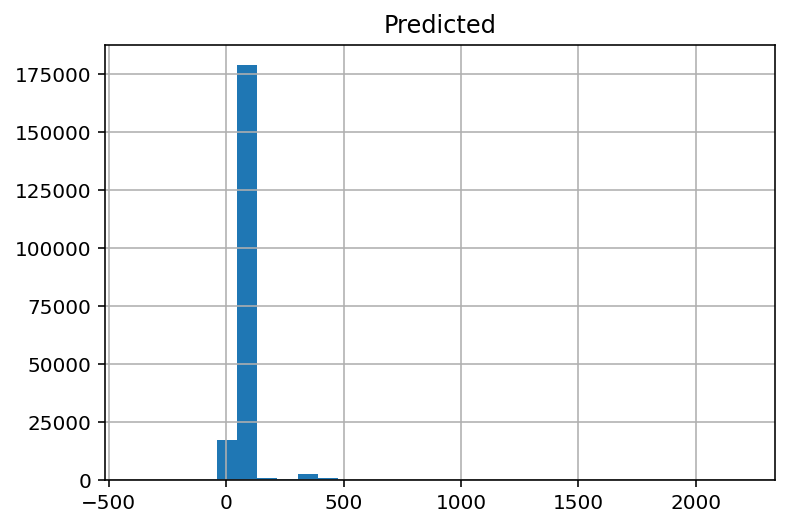

In [61]:
Predicted_humidity.hist(bins = 30)

In [62]:
def hundred (num):
    if num > 100:
        return 100
    elif num < 0:
        return 10
    else:
        return num
        

In [63]:
Predicted_humidity = Predicted_humidity['Predicted'].apply(hundred)

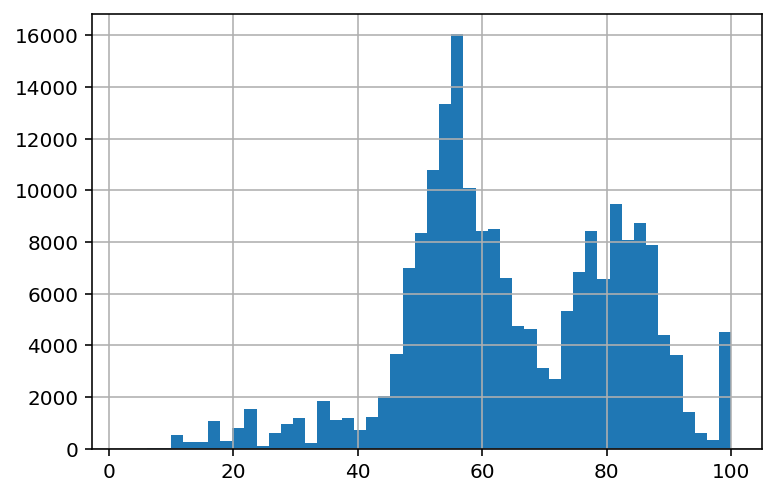

In [64]:
Predicted_humidity.hist(bins = 50)

In [84]:
all_y = all_data['Target']

In [85]:
df = pd.DataFrame({'Predicted':Predicted_humidity, 'Target': all_y})

In [86]:
def parameters_diff_classes (df, box_plots = True):
    if box_plots:
       sns.boxplot(x= df.columns[1], y = df.columns[0], data= df) 
    mean_std = pd.concat([df.groupby('Target').mean(),
                          df.groupby('Target').std(),
                         df.groupby('Target').median()], axis= 1)
    mean_std.columns = ['MEAN', 'STD', 'MEDIAN']
    diff_mean = np.abs(mean_std.loc[0, 'MEAN'] - mean_std.loc[1, 'MEAN']) ,
    diff_std = np.abs(mean_std.loc[0, 'STD'] - mean_std.loc[1, 'STD'])
    diff_median = np.abs(mean_std.loc[0, 'MEDIAN'] - mean_std.loc[1, 'MEDIAN'])
    diff_df = pd.DataFrame({'MEAN':   diff_mean, 'STD': diff_std, 'MEDIAN':diff_median})
    df = pd.concat([mean_std,  diff_df])
    df.index = [0, 1, 'difference between classes']
    return df

,MEAN,STD,MEDIAN
0,66.241133,17.483883,64.238769
1,59.767591,15.496168,56.898032
difference between classes,6.473542,1.987715,7.340737


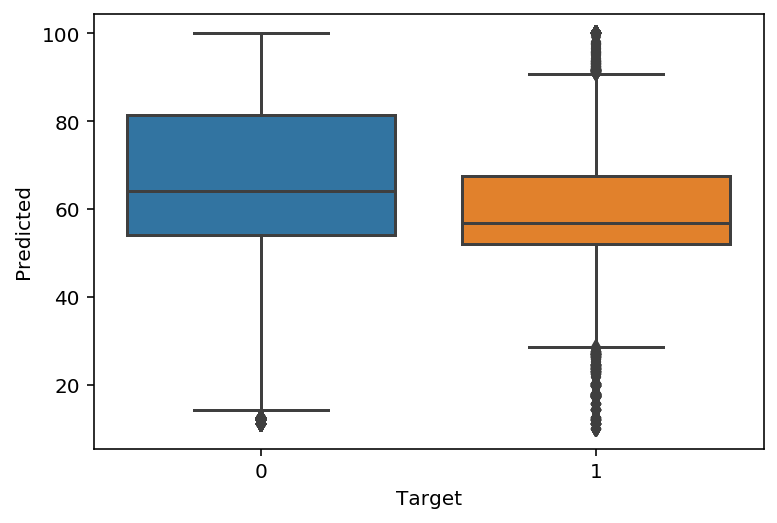

In [87]:
parameters_diff_classes(df)

In [65]:
all_data_state_y = all_data[['Month Dest Temp',
                             'Month Dest Prec',
                             'Month',
                             'Latitude_y',
                             'Longitude_y',
                             'Sun hours State_y',
                             'Clear days State_y',
                             'Humidity State_y',
                             'Land time']]

In [66]:
all_data_state_y['Land time'] = all_data_state_y['Land time'].apply(is_it_afternoon)
all_data_state_y['Month'] = all_data_state_y['Month'].astype(str)
all_data_state_y = pd.get_dummies(all_data_state_y)
all_data_state_y = all_data_state_y[['Month Dest Temp',
 'Month Dest Prec',
 'Latitude_y',
 'Longitude_y',
 'Sun hours State_y',
 'Clear days State_y',
 'Humidity State_y',
 'Land time',
 'Month_1',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12',]]
all_data_state_y.columns = data.columns

In [67]:
all_data_state_y_pow = add_power_features_to_test(all_data_state_y, power_features)
all_data_state_y_pow_mult = add_mult_features_to_test(all_data_state_y_pow, mult_features)

In [68]:
all_data_state_y_pow_mult_comb = add_mult_features_to_test(all_data_state_y_pow_mult, combined_features)

In [69]:
Predicted_humidity1 = pd.DataFrame({'Predicted':Lin_reg.predict(all_data_state_y_pow_mult_comb)})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f758045d790>]],
      dtype=object)

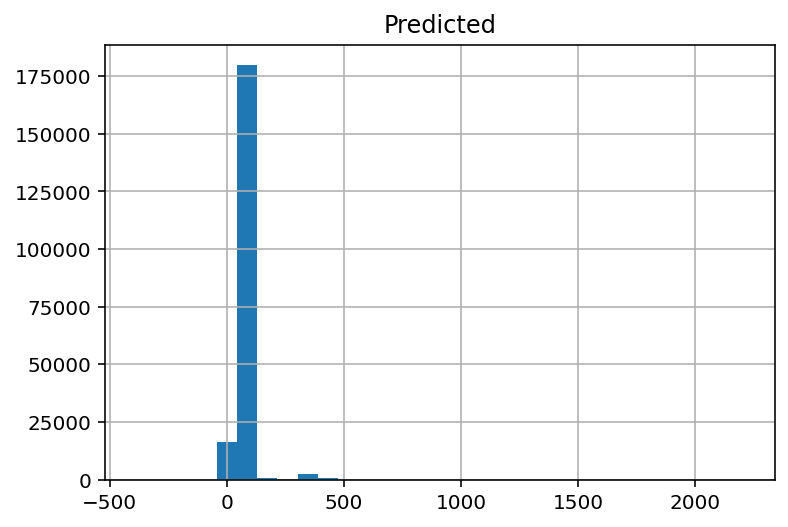

In [70]:
Predicted_humidity1.hist(bins = 30)

In [71]:
Predicted_humidity1 = Predicted_humidity1['Predicted'].apply(hundred)

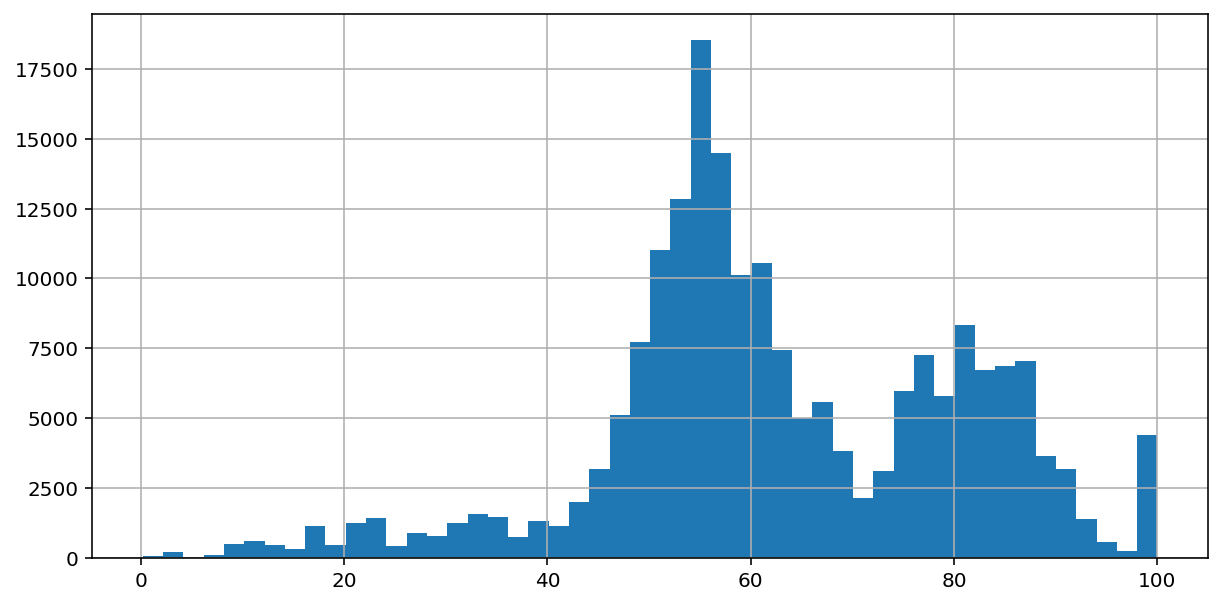

In [72]:
Predicted_humidity1.hist(bins = 50, figsize = (10, 5))

In [73]:
df1 = pd.DataFrame({'Predicted':Predicted_humidity1, 'Target': all_y})

NameError: name 'all_y' is not defined

,MEAN,STD,MEDIAN
0,63.865460,17.640745,60.798130
1,57.930445,16.673192,56.527095
difference between classes,5.935016,0.967553,4.271035


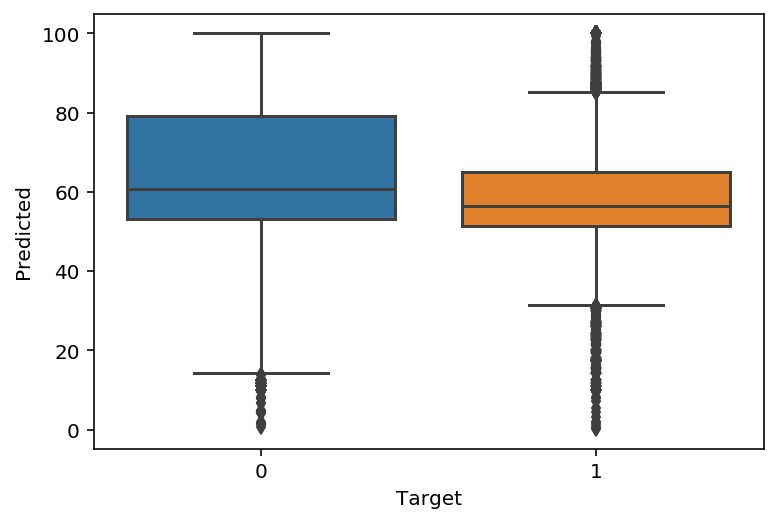

In [99]:
parameters_diff_classes(df1)

In [75]:
New_air_ports_data1 = pd.read_csv('Data for comp/Extended Air Port Data.csv')

In [76]:
Airport_acre = New_air_ports_data1[['IATA', 'Acre']]

In [77]:
data1 = pd.read_excel('Data for comp/Humidity1.xlsx')
data1 = data1[data1['Morning'] == 1]

In [78]:
dict_city_avg = dict()
dict_city_mill = dict()
Cities = set(data1['City'])
for city in Cities:
    df_city = data1[data1['City'] == city]
    inner_dict_avg = dict()
    inner_dict_mill = dict()
    for index in df_city.index:
        Month = df_city.loc[index,'Month']
        Avg = df_city.loc[index,'Avg ° C']
        Mill = df_city.loc[index,'Millimetres']
        inner_dict_avg[Month] = Avg
        inner_dict_mill[Month] = Mill
    dict_city_avg[city] = inner_dict_avg
    dict_city_mill[city] = inner_dict_mill

In [80]:
Cloud_df = pd.read_excel('Data for comp/Cloud.xlsx')

In [81]:
Cloud_df_cl = Cloud_df[['Season','Month','City','Cloud']]
Cloud_df_fog = Cloud_df[['Season','Month','City','Fog']]

In [82]:
Cloud_df_cl['State'] = Cloud_df_cl['City'].apply(lambda x: x.split(', ')[1])
Cloud_df_cl['city'] = Cloud_df_cl['City'].apply(lambda x: x.split(', ')[0])
Cloud_df_cl['State Humidity Morning'] = np.NaN
Cloud_df_cl['State Humidity Afternoon'] = np.NaN
Cloud_df_cl['State Sun Days'] = np.NaN
Cloud_df_cl['State Sun Hours'] = np.NaN
Cloud_df_cl['Avg Temperature'] = np.NaN
Cloud_df_cl['Avg Millimetres'] = np.NaN

In [83]:
for i in Cloud_df_cl.index:
    Season = Cloud_df_cl.loc[i,'Season']
    Month = Cloud_df_cl.loc[i,'Month']
    State = Cloud_df_cl.loc[i,'State']
    City = Cloud_df_cl.loc[i,'City']
    Cloud_df_cl.loc[i,'State Humidity Morning'] = dict_state_humidity[State]['Morning'][Season]
    Cloud_df_cl.loc[i,'State Humidity Afternoon'] = dict_state_humidity[State]['Afternoon'][Season]
    Cloud_df_cl.loc[i,'State Sun Days'] = dict_climate_sun_days[State][Season]
    Cloud_df_cl.loc[i,'State Sun Hours'] = dict_climate_sun_hours[State][Season]
    Cloud_df_cl.loc[i,'Avg Temperature'] = dict_city_avg[City][Month]
    Cloud_df_cl.loc[i,'Avg Millimetres'] = dict_city_mill[City][Month]
Cloud_df_cl = Cloud_df_cl.merge(Cities_corr, left_on= 'city', right_on= 'City', how= 'left')
Cloud_df_cl = Cloud_df_cl.sample(frac=1)
Cloud_df_cl = Cloud_df_cl.sample(frac = 1)
y_cloud = Cloud_df_cl['Cloud']
Cloud_df_cl.drop(columns = ['City_x', 'State', 'city','City_y', 'Season', 'Cloud'], inplace = True)
Cloud_df_cl['Month'] = Cloud_df_cl['Month'].astype(str)
Cloud_df_cl = pd.get_dummies(Cloud_df_cl)

In [84]:
Cloud_df_fog['State'] = Cloud_df_fog['City'].apply(lambda x: x.split(', ')[1])
Cloud_df_fog['city'] = Cloud_df_fog['City'].apply(lambda x: x.split(', ')[0])
Cloud_df_fog['State Humidity Morning'] = np.NaN
Cloud_df_fog['State Humidity Afternoon'] = np.NaN
Cloud_df_fog['State Sun Days'] = np.NaN
Cloud_df_fog['State Sun Hours'] = np.NaN
Cloud_df_fog['Avg Temperature'] = np.NaN
Cloud_df_fog['Avg Millimetres'] = np.NaN
for i in Cloud_df_fog.index:
    Season = Cloud_df_fog.loc[i,'Season']
    Month = Cloud_df_fog.loc[i,'Month']
    State = Cloud_df_fog.loc[i,'State']
    City = Cloud_df_fog.loc[i,'City']
    Cloud_df_fog.loc[i,'State Humidity Morning'] = dict_state_humidity[State]['Morning'][Season]
    Cloud_df_fog.loc[i,'State Humidity Afternoon'] = dict_state_humidity[State]['Afternoon'][Season]
    Cloud_df_fog.loc[i,'State Sun Days'] = dict_climate_sun_days[State][Season]
    Cloud_df_fog.loc[i,'State Sun Hours'] = dict_climate_sun_hours[State][Season]
    Cloud_df_fog.loc[i,'Avg Temperature'] = dict_city_avg[City][Month]
    Cloud_df_fog.loc[i,'Avg Millimetres'] = dict_city_mill[City][Month]
Cloud_df_fog = Cloud_df_fog.merge(Cities_corr, left_on= 'city', right_on= 'City', how= 'left')
Cloud_df_fog = Cloud_df_fog.sample(frac=1)
Cloud_df_fog = Cloud_df_fog.sample(frac = 1)
y_fog = Cloud_df_fog['Fog']
Cloud_df_fog.drop(columns = ['City_x', 'State', 'city','City_y', 'Season', 'Fog'], inplace = True)
Cloud_df_fog['Month'] = Cloud_df_fog['Month'].astype(str)
Cloud_df_fog = pd.get_dummies(Cloud_df_fog)

In [85]:
cloud_all_data_origin = all_data[['Season', 'Month','State_x', 'Clear days State_x','Sun hours State_x',
                                  'Month Origin Temp','Month Origin Prec','Latitude_x','Longitude_x']]

In [86]:
cloud_all_data_origin['Humidity state morning'] = np.NaN
cloud_all_data_origin['Humidity state afternoon'] = np.NaN
for i in cloud_all_data_origin.index:
    State = cloud_all_data_origin.loc[i,'State_x']
    Season = cloud_all_data_origin.loc[i,'Season']
    cloud_all_data_origin.loc[i,'Humidity state morning'] = dict_state_humidity[State]['Morning'][Season]
    cloud_all_data_origin.loc[i,'Humidity state afternoon'] = dict_state_humidity[State]['Afternoon'][Season]

In [87]:
cloud_all_data_origin.drop(columns=['Season', 'State_x'], inplace= True)
cloud_all_data_origin['Month'] = cloud_all_data_origin['Month'].astype(str)

In [88]:
cloud_all_data_origin = cloud_all_data_origin[['Humidity state morning',
                                               'Humidity state afternoon',
                                               'Clear days State_x',
                                               'Sun hours State_x',
                                               'Month Origin Temp',
                                               'Month Origin Prec',
                                               'Latitude_x',
                                               'Longitude_x',
                                               'Month']]

In [96]:
cloud_all_data_origin = pd.get_dummies(cloud_all_data_origin)

In [98]:
cloud_all_data_origin.columns = Cloud_df_cl.columns

In [99]:
Cloud_df_cl_power = power_fetures(Lin_reg, Cloud_df_cl, y_cloud, thresh = 5, power_= 8 , num_cv = 5, add_features = False)

In [100]:
Cloud_df_cl_mult = mult_fetures (Lin_reg, Cloud_df_cl, y_cloud, thresh = 5, num_cv = 5, max_features = True, add_features = False)

In [101]:
Cloud_df_cl_power_mult = pd.concat([Cloud_df_cl,Cloud_df_cl_power,Cloud_df_cl_mult], axis = 1)

In [102]:
Power_features_cl = Cloud_df_cl_power.columns
Mult_features_cl = Cloud_df_cl_mult.columns

In [95]:
mean1 = cloud_all_data_origin['State Humidity Morning'].mean()
mean2 = cloud_all_data_origin['State Humidity Afternoon'].mean()
cloud_all_data_origin['State Humidity Morning'] = cloud_all_data_origin['State Humidity Morning'].fillna(mean1)
cloud_all_data_origin['State Humidity Afternoon'] = cloud_all_data_origin['State Humidity Afternoon'].fillna(mean2)

In [103]:
cloud_all_data_origin_power = add_power_features_to_test(cloud_all_data_origin, Power_features_cl)
cloud_all_data_origin_mult = add_mult_features_to_test(cloud_all_data_origin_power, Mult_features_cl)

In [104]:
cloud_all_data_dest = all_data[['Season', 'Month','State_y', 'Clear days State_y','Sun hours State_y',
                                  'Month Dest Temp','Month Dest Prec','Latitude_y','Longitude_y']]
cloud_all_data_dest['Humidity state morning'] = np.NaN
cloud_all_data_dest['Humidity state afternoon'] = np.NaN
for i in cloud_all_data_dest.index:
    State = cloud_all_data_dest.loc[i,'State_y']
    Season = cloud_all_data_dest.loc[i,'Season']
    cloud_all_data_dest.loc[i,'Humidity state morning'] = dict_state_humidity[State]['Morning'][Season]
    cloud_all_data_dest.loc[i,'Humidity state afternoon'] = dict_state_humidity[State]['Afternoon'][Season]
cloud_all_data_dest.drop(columns=['Season', 'State_y'], inplace= True)
cloud_all_data_dest['Month'] = cloud_all_data_dest['Month'].astype(str)
cloud_all_data_dest = cloud_all_data_dest[['Humidity state morning',
                                               'Humidity state afternoon',
                                               'Clear days State_y',
                                               'Sun hours State_y',
                                               'Month Dest Temp',
                                               'Month Dest Prec',
                                               'Latitude_y',
                                               'Longitude_y',
                                               'Month']]
cloud_all_data_dest = pd.get_dummies(cloud_all_data_dest)
cloud_all_data_dest.columns = Cloud_df_cl.columns

In [105]:
mean11 = cloud_all_data_dest['State Humidity Morning'].mean()
mean22 = cloud_all_data_dest['State Humidity Afternoon'].mean()
cloud_all_data_dest['State Humidity Morning'] = cloud_all_data_dest['State Humidity Morning'].fillna(mean11)
cloud_all_data_dest['State Humidity Afternoon'] = cloud_all_data_dest['State Humidity Afternoon'].fillna(mean22)

In [106]:
cloud_all_data_dest_power = add_power_features_to_test(cloud_all_data_dest, Power_features_cl)
cloud_all_data_dest_mult = add_mult_features_to_test(cloud_all_data_dest_power, Mult_features_cl)

In [107]:
Lin_reg.fit(Cloud_df_cl_power_mult, y_cloud)

LinearRegression(n_jobs=-1)

In [108]:
Predicted_cloud_origin = Lin_reg.predict(cloud_all_data_origin_mult)
Predicted_cloud_dest = Lin_reg.predict(cloud_all_data_dest_mult)

In [133]:
Skf = StratifiedKFold(n_splits= 5, random_state= 17
                     )
scores_fog = cross_val_score(Lin_reg,fog_power_mult, y_fog, cv = Skf, scoring = 'r2')

In [134]:
scores_fog, scores_fog.mean(), scores_fog.std()

(array([0.76372979, 0.72525627, 0.80837017, 0.81518804, 0.76489355]),
 0.7754875629147283,
 0.03295771536650862)

In [111]:
fog_power = power_fetures(Lin_reg,
                                 Cloud_df_fog,
                                 y_fog,
                                 thresh = 5,
                                 power_= 8 ,
                                 num_cv = 10,
                                 add_features = False)

In [112]:
fog_mult = mult_fetures (Lin_reg,
                                 Cloud_df_fog, 
                                 y_fog, 
                                 thresh = 5,
                                 num_cv = 10, 
                                 max_features = True,
                                 add_features = False)

In [113]:
data_fog_power = pd.concat([Cloud_df_fog, fog_power], axis = 1)

In [114]:
combined_features = mult_fetures (Lin_reg,
                                 data_fog_power, 
                                 y_fog, 
                                 thresh = 5,
                                 num_cv = 10, 
                                 mult_comb= 2,
                                 add_features = False)

In [115]:
intersection = set(combined_features).intersection(set(fog_mult))

In [116]:
combined_features.drop(columns = intersection, inplace = True)

In [132]:
fog_power_mult = pd.concat([Cloud_df_fog,fog_power,fog_mult], axis = 1)

In [135]:
fog_power_fetures = fog_power.columns
fog_mult_features = fog_mult.columns


In [136]:
fog_data_origin_power = add_power_features_to_test(cloud_all_data_origin , fog_power_fetures)
fog_data_origin_power_mult = add_mult_features_to_test(fog_data_origin_power,fog_mult_features)


In [138]:
Lin_reg.fit(fog_power_mult, y_fog)

LinearRegression(n_jobs=-1)

In [139]:
Predicted_origin_fog  = Lin_reg.predict(fog_data_origin_power_mult)

In [140]:
def origin_fog_mean (num):
    if num > 30:
        return 21.508794232883446
    elif num < 0:
        return 0
    else:
        return num

In [141]:
def dest_fog_mean (num):
    if num > 30:
        return 21.683486841225378
    elif num < 0:
        return 0
    else:
        return num

In [145]:
df1 = pd.DataFrame({'Predicted':Predicted_origin_fog})
df1['Predicted'] = df1['Predicted'].apply( origin_fog_mean )

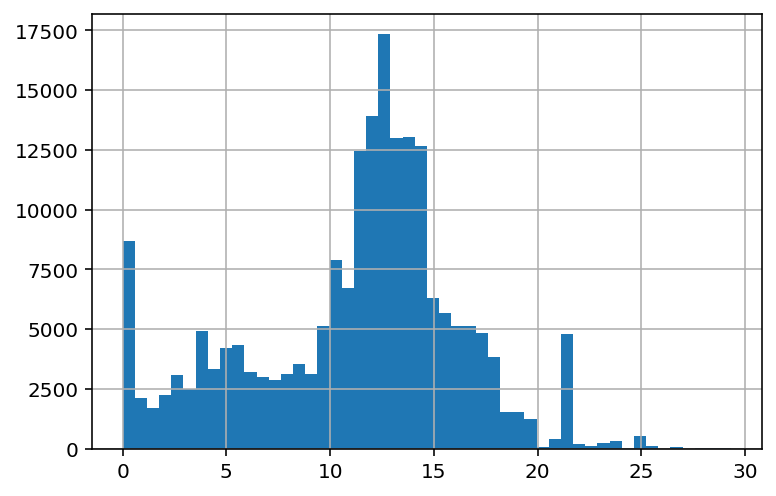

In [152]:
df1['Predicted'].hist(bins = 50)

In [147]:
fog_data_dest_power = add_power_features_to_test(cloud_all_data_dest , fog_power_fetures)
fog_data_dest_power_mult = add_mult_features_to_test(fog_data_dest_power,fog_mult_features)


In [148]:
Predicted_dest_fog  = Lin_reg.predict(fog_data_dest_power_mult)

In [149]:
df2 = pd.DataFrame({'Predicted':Predicted_dest_fog})
df2['Predicted'] = df2['Predicted'].apply(dest_fog_mean)

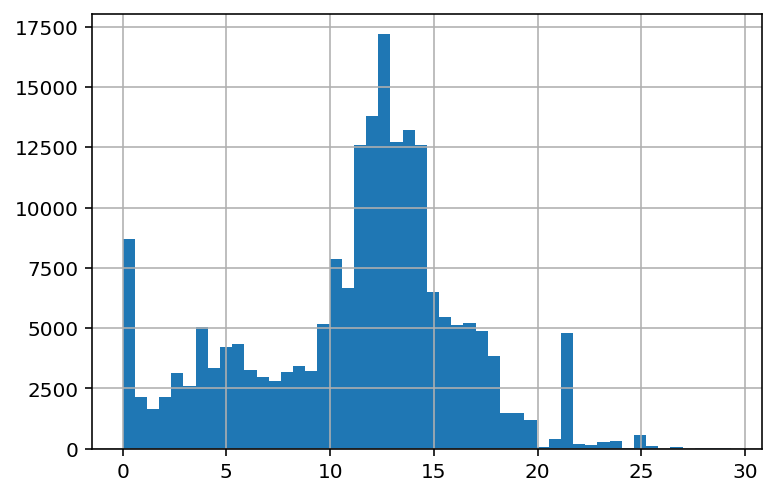

In [151]:
df2['Predicted'].hist(bins = 50)

,MEAN,STD,MEDIAN
0,10.754494,5.120969,12.028358
1,11.123707,4.968653,12.302490
difference between classes,0.369213,0.152316,0.274132


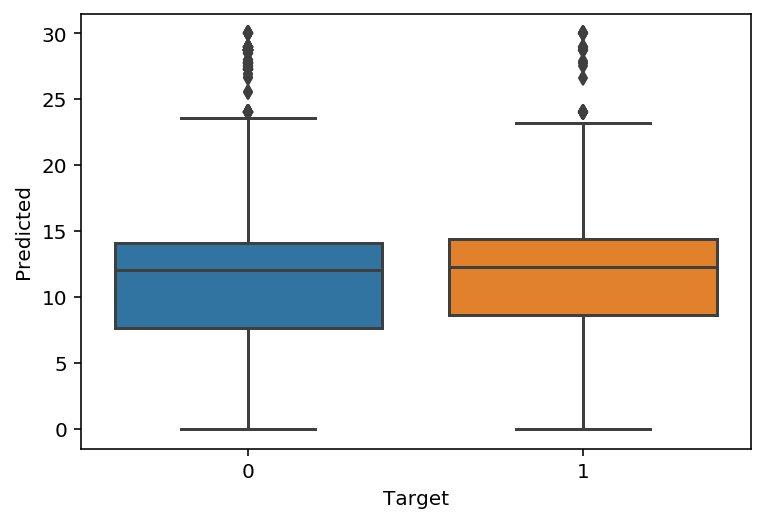

In [166]:
parameters_diff_classes(df1)

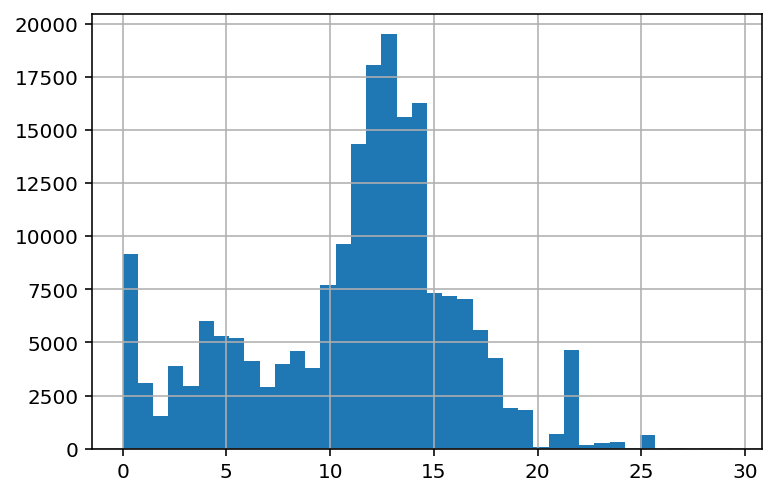

In [153]:
df2['Predicted'].hist(bins = 40)

In [154]:
Sun_data = pd.read_excel('Data for comp/Sun Data.xlsx')

In [155]:
State_sun_percent = pd.read_excel('Data for comp/Sun Percent State.xlsx')

In [156]:
Sun_data['State'] = Sun_data['City'].apply(lambda x: x.split(', ')[1])
Sun_data['city'] = Sun_data['City'].apply(lambda x: x.split(', ')[0])
Sun_data['State Humidity Morning'] = np.NaN
Sun_data['State Humidity Afternoon'] = np.NaN
Sun_data['State Sun Days'] = np.NaN
Sun_data['State Sun Hours'] = np.NaN
Sun_data['Avg Temperature'] = np.NaN
Sun_data['Avg Millimetres'] = np.NaN
for i in Sun_data.index:
    Season = Sun_data.loc[i,'Season']
    Month = Sun_data.loc[i,'Month']
    State = Sun_data.loc[i,'State']
    City = Sun_data.loc[i,'City']
    Sun_data.loc[i,'State Humidity Morning'] = dict_state_humidity[State]['Morning'][Season]
    Sun_data.loc[i,'State Humidity Afternoon'] = dict_state_humidity[State]['Afternoon'][Season]
    Sun_data.loc[i,'State Sun Days'] = dict_climate_sun_days[State][Season]
    Sun_data.loc[i,'State Sun Hours'] = dict_climate_sun_hours[State][Season]
    Sun_data.loc[i,'Avg Temperature'] = dict_city_avg[City][Month]
    Sun_data.loc[i,'Avg Millimetres'] = dict_city_mill[City][Month]
Sun_data = Sun_data.merge(Cities_corr, left_on= 'city', right_on= 'City', how= 'left')
Sun_data = Sun_data.sample(frac=1)
Sun_data = Sun_data.sample(frac = 1)
y__clear_days = Sun_data['Clear Days']
Y_per_sun = Sun_data['% Sun']
Sun_data.drop(columns = ['City_x', 'city','City_y', 'Clear Days', '% Sun'], inplace = True)
Sun_data['Month'] = Sun_data['Month'].astype(str)

In [157]:
Dict_State_sun_percent = dict()
for state in set(State_sun_percent['State']):
    State_df = State_sun_percent[State_sun_percent['State'] == state]
    Inner_dict = dict()
    for i in State_df.index:
        Season = State_df.loc[i,'Season']
        Sun_percent = State_df.loc[i,'% Sun']
        Inner_dict[Season] = Sun_percent
    Dict_State_sun_percent[state] = Inner_dict

In [158]:
Sun_data['State Sun Percent'] = np.NaN

In [159]:
for i in Sun_data.index:
    try:
        Season = Sun_data.loc[i, 'Season']
        State = Sun_data.loc[i, 'State']
        Sun_data.loc[i,'State Sun Percent'] =  Dict_State_sun_percent[State][Season]
    except:
        continue

In [160]:
dict_mean_season = dict()
for season in  set(Sun_data['Season']):
    df = Sun_data[Sun_data['Season'] == season]
    mean = df['State Sun Percent'].mean()
    dict_mean_season[season] = mean
for i in Sun_data[Sun_data['State Sun Percent'].isna()].index:
    Season = Sun_data.loc[i, 'Season']
    Sun_data.loc[i,'State Sun Percent'] = dict_mean_season[Season]

In [161]:
Sun_data.drop(columns=['Season','State'], inplace= True)
Sun_data = pd.get_dummies(Sun_data)

In [162]:
Lin_reg = LinearRegression(n_jobs= -1)
Skf = StratifiedKFold(n_splits= 5, random_state= 17)

In [166]:
scores = cross_val_score(Lin_reg, Sun_data_power_mult, Y_per_sun, cv = Skf, scoring = 'r2')

In [167]:
scores.mean(), scores.std(), scores 

(0.8992218071220103,
 0.011310449730830096,
 array([0.88422838, 0.89178038, 0.90746401, 0.91608553, 0.89655075]))

In [163]:
Sun_data_power = power_fetures(Lin_reg, Sun_data, Y_per_sun, thresh = 5, power_= 8, num_cv= 10)
Sun_data_mult = mult_fetures(Lin_reg, Sun_data, Y_per_sun, thresh = 5, max_features= True, num_cv= 10)

In [164]:
Sun_data_power_features = Sun_data_power.columns
Sun_data_mult_fetures = Sun_data_mult.columns

In [165]:
Sun_data_power_mult = pd.concat([Sun_data, Sun_data_power,Sun_data_mult], axis= 1)

In [168]:
sun_data_dest = all_data[['Season', 'Month','State_y', 'Clear days State_y','Sun hours State_y',
                                  'Month Dest Temp','Month Dest Prec','Latitude_y','Longitude_y']]
sun_data_dest['Humidity state morning'] = np.NaN
sun_data_dest['Humidity state afternoon'] = np.NaN
for i in sun_data_dest.index:
    State = sun_data_dest.loc[i,'State_y']
    Season = sun_data_dest.loc[i,'Season']
    sun_data_dest.loc[i,'Humidity state morning'] = dict_state_humidity[State]['Morning'][Season]
    sun_data_dest.loc[i,'Humidity state afternoon'] = dict_state_humidity[State]['Afternoon'][Season]
sun_data_dest['Month'] = sun_data_dest['Month'].astype(str)

In [169]:
sun_data_dest['State Sun Percent'] = np.NaN
for i in sun_data_dest.index:
    try:
        Season = sun_data_dest.loc[i, 'Season']
        State = sun_data_dest.loc[i, 'State_y']
        sun_data_dest.loc[i,'State Sun Percent'] =  Dict_State_sun_percent[State][Season]
    except:
        continue

In [170]:
dict_mean_season_1 = dict()
for season in  set(sun_data_dest['Season']):
    df = Sun_data[sun_data_dest['Season'] == season]
    mean = df['State Sun Percent'].mean()
    dict_mean_season_1[season] = mean
for i in sun_data_dest[sun_data_dest['State Sun Percent'].isna()].index:
    Season = sun_data_dest.loc[i, 'Season']
    sun_data_dest.loc[i,'State Sun Percent'] = dict_mean_season_1[Season]

In [171]:
mean_sun_1 = sun_data_dest['Humidity state morning'].mean()
mean_sun_2 = sun_data_dest['Humidity state afternoon'].mean()
sun_data_dest['Humidity state morning'] = sun_data_dest['Humidity state morning'].fillna(mean_sun_1)
sun_data_dest['Humidity state afternoon'] = sun_data_dest['Humidity state afternoon'].fillna(mean_sun_2)

In [172]:
sun_data_dest.drop(columns=['Season','State_y'], inplace= True)

In [173]:
sun_data_dest = sun_data_dest[['Humidity state morning',
                                               'Humidity state afternoon',
                                               'Clear days State_y',
                                               'Sun hours State_y',
                                               'Month Dest Temp',
                                               'Month Dest Prec',
                                               'Latitude_y',
                                               'Longitude_y',
                                            'State Sun Percent',
                                               'Month']]

In [174]:
sun_data_dest = pd.get_dummies(sun_data_dest)

In [175]:
sun_data_dest.columns = Sun_data.columns

In [176]:
sun_data_dest_power = add_power_features_to_test(sun_data_dest, Sun_data_power_features)
sun_data_dest_power_mult = add_mult_features_to_test(sun_data_dest_power, Sun_data_mult_fetures)

In [177]:
Lin_reg.fit(Sun_data_power_mult, Y_per_sun)

LinearRegression(n_jobs=-1)

In [178]:
Predicted_sun_recent_dest = Lin_reg.predict(sun_data_dest_power_mult)

In [179]:
def make_range_sun (num):
    if num > 100:
        return 100
    elif num < 0:
        return 0
    else:
        return num

In [180]:
df_sun = pd.DataFrame({'Predicted':Predicted_sun_recent_dest})
df_sun['Predicted'] = df_sun['Predicted'].apply(make_range_sun)

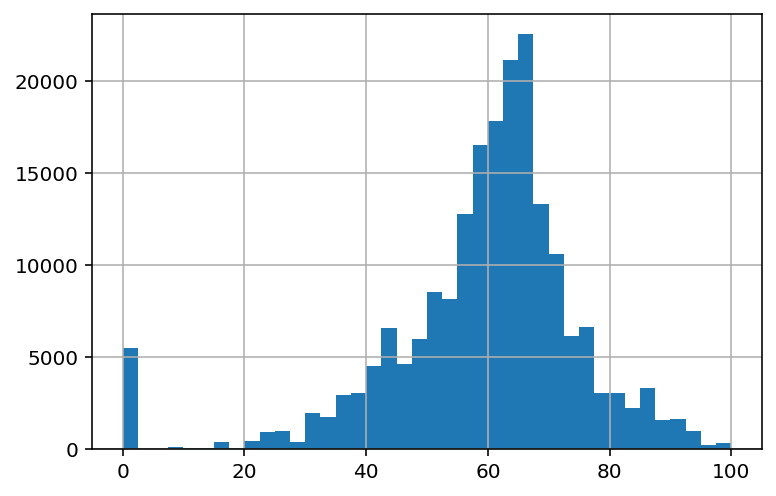

In [181]:
df_sun['Predicted'].hist(bins = 40)

,MEAN,STD,MEDIAN
0,61.265805,14.614153,61.993676
1,60.374331,14.574586,61.792220
difference between classes,0.891474,0.039567,0.201456


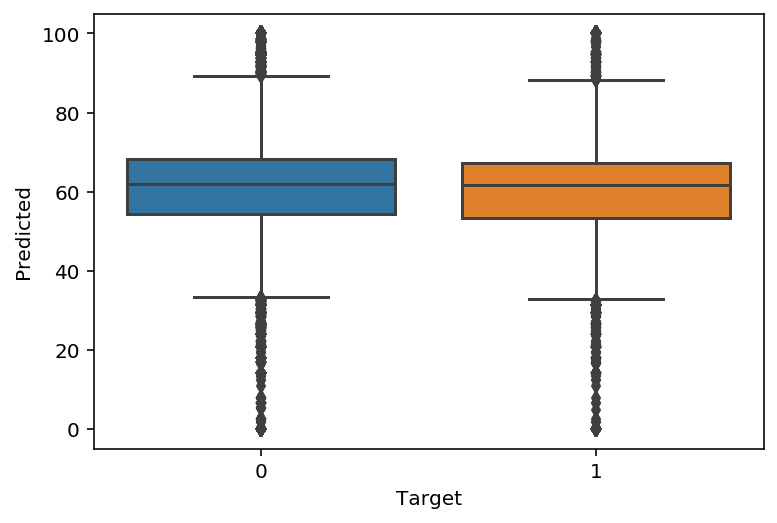

In [232]:
parameters_diff_classes(df_sun)

In [182]:
sun_data_origin = all_data[['Season', 'Month','State_x', 'Clear days State_x','Sun hours State_x',
                                  'Month Origin Temp','Month Origin Prec','Latitude_x','Longitude_x']]
sun_data_origin['Humidity state morning'] = np.NaN
sun_data_origin['Humidity state afternoon'] = np.NaN
for i in sun_data_origin.index:
    State = sun_data_origin.loc[i,'State_x']
    Season = sun_data_origin.loc[i,'Season']
    sun_data_origin.loc[i,'Humidity state morning'] = dict_state_humidity[State]['Morning'][Season]
    sun_data_origin.loc[i,'Humidity state afternoon'] = dict_state_humidity[State]['Afternoon'][Season]
sun_data_origin['Month'] = sun_data_origin['Month'].astype(str)
sun_data_origin['State Sun Percent'] = np.NaN
for i in sun_data_dest.index:
    try:
        Season = sun_data_origin.loc[i, 'Season']
        State = sun_data_origin.loc[i, 'State_x']
        sun_data_origin.loc[i,'State Sun Percent'] =  Dict_State_sun_percent[State][Season]
    except:
        continue
dict_mean_season_2 = dict()
for season in  set(sun_data_origin['Season']):
    df = Sun_data[sun_data_origin['Season'] == season]
    mean = df['State Sun Percent'].mean()
    dict_mean_season_2[season] = mean
for i in sun_data_origin[sun_data_origin['State Sun Percent'].isna()].index:
    Season = sun_data_origin.loc[i, 'Season']
    sun_data_origin.loc[i,'State Sun Percent'] = dict_mean_season_2[Season]
mean_sun_11 = sun_data_origin['Humidity state morning'].mean()
mean_sun_22 = sun_data_origin['Humidity state afternoon'].mean()
sun_data_origin['Humidity state morning'] = sun_data_origin['Humidity state morning'].fillna(mean_sun_11)
sun_data_origin['Humidity state afternoon'] = sun_data_origin['Humidity state afternoon'].fillna(mean_sun_22)
sun_data_origin.drop(columns=['Season','State_x'], inplace= True)
sun_data_origin = sun_data_origin[['Humidity state morning',
                                               'Humidity state afternoon',
                                               'Clear days State_x',
                                               'Sun hours State_x',
                                               'Month Origin Temp',
                                               'Month Origin Prec',
                                               'Latitude_x',
                                               'Longitude_x',
                                            'State Sun Percent',
                                               'Month']]
sun_data_origin = pd.get_dummies(sun_data_origin)

In [183]:
sun_data_origin.columns = Sun_data.columns

In [184]:
sun_data_origin_power = add_power_features_to_test(sun_data_origin, Sun_data_power_features)
sun_data_origin_power_mult = add_mult_features_to_test(sun_data_origin_power, Sun_data_mult_fetures)

In [185]:
Predicted_sun_recent_origin = Lin_reg.predict(sun_data_origin_power_mult)

In [186]:
df_sun1 = pd.DataFrame({'Predicted':Predicted_sun_recent_origin})
df_sun1['Predicted'] = df_sun1['Predicted'].apply(make_range_sun)

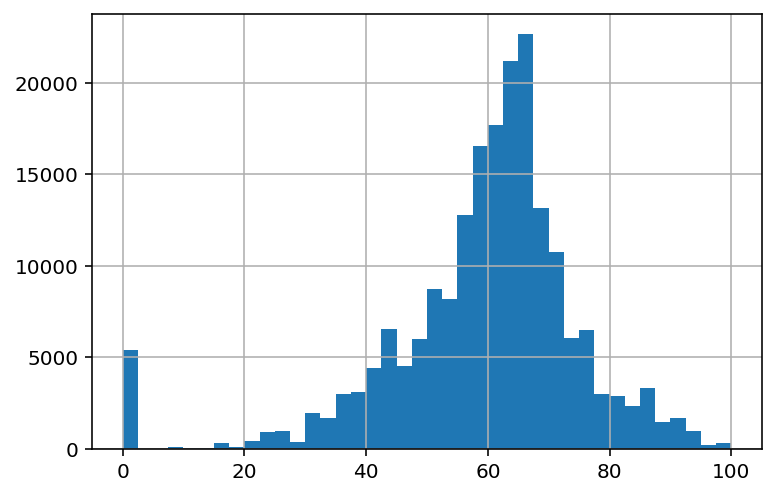

In [187]:
df_sun1['Predicted'].hist(bins = 40)

,MEAN,STD,MEDIAN
0,61.310523,14.640998,61.993676
1,60.425832,14.383888,61.853663
difference between classes,0.884691,0.257110,0.140013


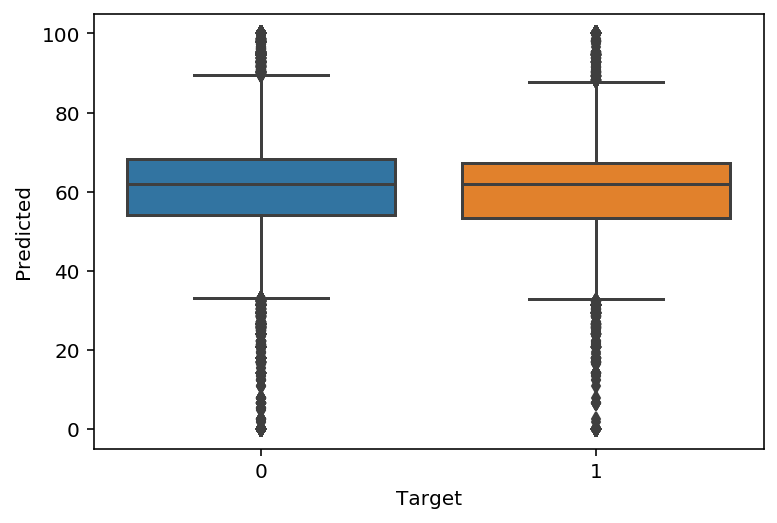

In [239]:
parameters_diff_classes(df_sun1)

In [188]:
Clear_days_power = power_fetures(Lin_reg, Sun_data, y__clear_days, thresh = 5, power_= 8, num_cv= 10)
Clear_days_mult = mult_fetures(Lin_reg, Sun_data, y__clear_days, thresh = 5, max_features= True, num_cv= 10)

In [189]:
Clear_days_power_mult = pd.concat([Sun_data,Clear_days_power,Clear_days_mult], axis = 1)
Lin_reg.fit(Clear_days_power_mult, y__clear_days)

LinearRegression(n_jobs=-1)

In [190]:
Clear_days_power_features = Clear_days_power.columns 
Clear_days_mult_features = Clear_days_mult.columns

In [191]:
Clear_days_origin_power = add_power_features_to_test(sun_data_origin, Clear_days_power_features)
Clear_days_origin_power_mult = add_mult_features_to_test(Clear_days_origin_power, Clear_days_mult_features)

In [192]:
Clear_days_dest_power = add_power_features_to_test(sun_data_dest, Clear_days_power_features)
Clear_days_dest_power_mult = add_mult_features_to_test(Clear_days_dest_power, Clear_days_mult_features)

In [193]:
Predicted_clear_days_origin = Lin_reg.predict(Clear_days_origin_power_mult)
Predicted_clear_days_dest =  Lin_reg.predict(Clear_days_dest_power_mult)

In [194]:
def make_range (num):
    if num > 30:
        return 30
    elif num < 0:
        return 0
    else:
        return num

In [195]:
df_clear_days_origin = pd.DataFrame({'Predicted':Predicted_clear_days_origin})
df_clear_days_dest = pd.DataFrame({'Predicted':Predicted_clear_days_dest})
df_clear_days_origin['Predicted'] = df_clear_days_origin['Predicted'].apply(make_range)
df_clear_days_dest['Predicted'] = df_clear_days_dest['Predicted'].apply(make_range)

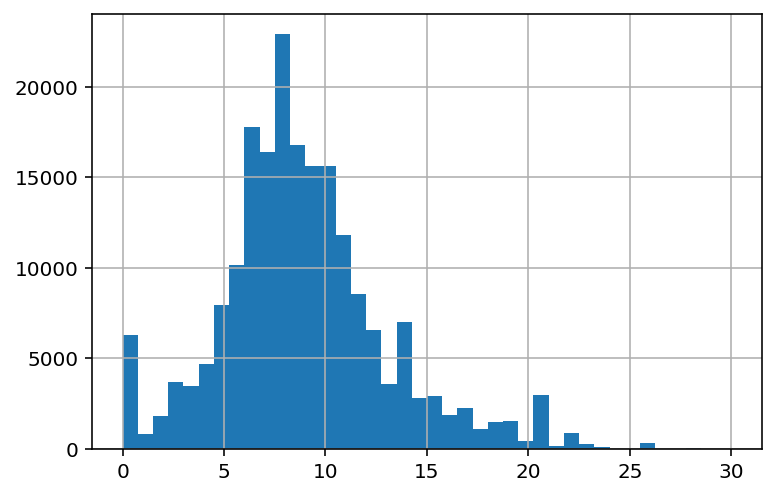

In [196]:
df_clear_days_dest['Predicted'].hist(bins = 40)

,MEAN,STD,MEDIAN
0,8.967025,4.609416,8.562843
1,8.820939,4.463515,8.353760
difference between classes,0.146085,0.145901,0.209083


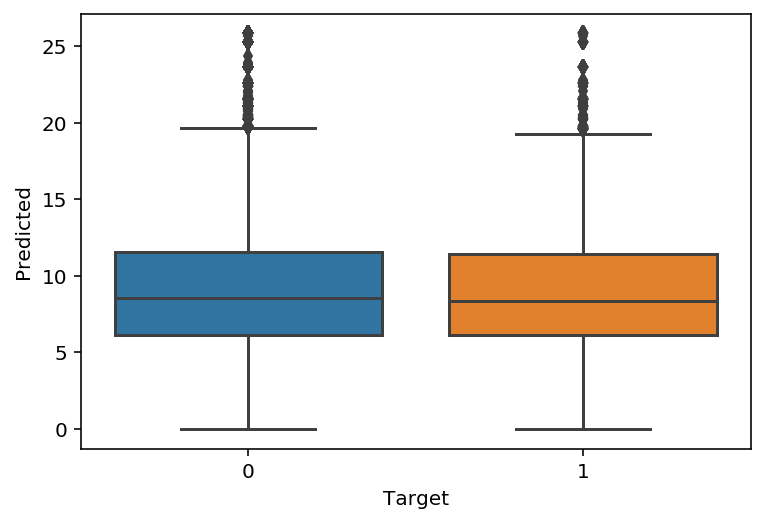

In [264]:
parameters_diff_classes(df_clear_days_dest)

In [197]:
all_data['Predicted Origin humidity'] = Predicted_humidity
all_data['Predicted Dest humidity'] = Predicted_humidity1
all_data['Predicted Sun percent Origin'] = Predicted_sun_recent_origin
all_data['Predicted Sun percent Dest'] = Predicted_sun_recent_dest
all_data['Predicted Cloud days Origin'] = Predicted_cloud_origin
all_data['Predicted Cloud days Dest'] = Predicted_cloud_dest
all_data['Predicted Fog Days Origin'] = Predicted_origin_fog
all_data['Predicted Fog Days Dest'] = Predicted_dest_fog
all_data['Predicted Clear days Origin'] = Predicted_clear_days_origin
all_data['Predicted Clear days Dest'] = Predicted_clear_days_dest

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f757912df10>,
      dtype=object)

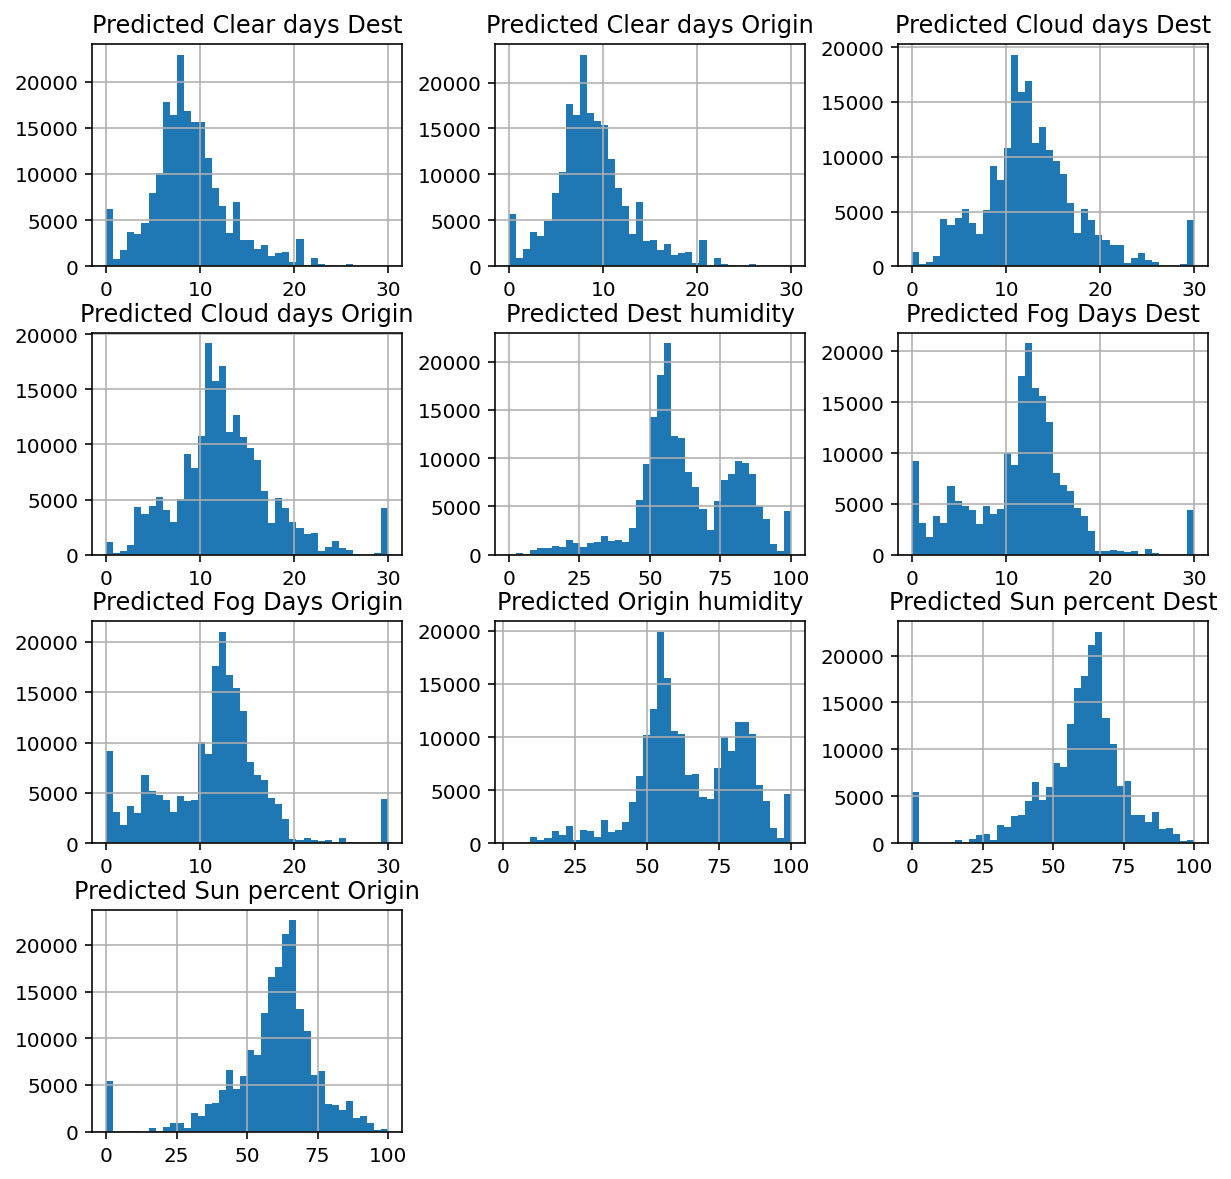

In [200]:
all_data.loc[:, 'Predicted Origin humidity':'Predicted Clear days Dest'].hist(figsize = (10, 10), bins = 40)

In [201]:
range_100 = ['Predicted Sun percent Origin','Predicted Sun percent Dest']
range_30 = ['Predicted Cloud days Origin',
             'Predicted Cloud days Dest',
             'Predicted Fog Days Origin',
             'Predicted Fog Days Dest',
             'Predicted Clear days Origin',
             'Predicted Clear days Dest' ]

In [199]:
def make_range_30 (num):
    if num > 30:
        return 30
    elif num < 0:
        return 0
    else:
        return num
def make_range_100 (num):
    if num > 100:
        return 100
    elif num < 0:
        return 0
    else:
        return num
for col in range_100:
    mean_col = all_data[col].mean()
    all_data[col] = all_data[col].apply(make_range_100)
for col in range_30:
    mean_col = all_data[col].mean()
    all_data[col] = all_data[col].apply(make_range_30)

In [202]:
New_air_ports_data_ = pd.read_csv('Data for comp/Extended Air Port Data.csv')

In [203]:
Airport_acre = New_air_ports_data_[['IATA', 'Acre']]

In [204]:
all_data = all_data.merge(Airport_acre, left_on='Origin', right_on='IATA')

In [205]:
all_data = all_data.merge(Airport_acre, left_on='Dest', right_on='IATA')

In [206]:
all_data.drop(columns=['IATA_x', 'IATA_y'], inplace= True)

In [207]:
all_data.sort_values(by = 'Unnamed: 0', inplace= True)

In [208]:
all_data.index = np.arange(all_data.shape[0])

In [210]:
all_data.to_csv('Extended all data acre climate.csv')

In [211]:
all_data

,Unnamed: 0,Month,DayofMonth,DayOfWeek,DepTime,Dep part of day,Distance,Season,Is it holyday,Is it weekend,Part of month,Land time,Land part of day,UniqueCarrier,Origin,Dest,Origin_City,State_x,Dest_City,State_y,Origin_Population,Dest_Population,AL_in_Top_fleet_size,AL_in_Top_passengers_carried,Origin airport in top,Dest airport in top,Avg ° C Temp State_x,Prec Mill State_x,Sun hours State_x,Clear days State_x,Humidity,Avg ° C Temp State_y,Prec Mill State_y,Sun hours State_y,Clear days State_y,Humidity State_y,Target,Month Origin Temp,Month Origin Prec,Month Dest Temp,Month Dest Prec,Latitude_x,Longitude_x,Latitude_y,Longitude_y,Predicted Origin humidity,Predicted Dest humidity,Predicted Sun percent Origin,Predicted Sun percent Dest,Predicted Cloud days Origin,Predicted Cloud days Dest,Predicted Fog Days Origin,Predicted Fog Days Dest,Predicted Clear days Origin,Predicted Clear days Dest,Acre_x,Acre_y
0,0,8,21,7,1934,Evening,732,Summer,Not Holyday,weekend,3.0,1952,Evening,AA,ATL,DFW,Atlanta Georgia,Georgia,Dallas Texas,Texas,491670.0,1342479.0,0,0,1,1,25.9,120.0,882.0,22.0,54.0,27.3,69.0,935.0,41.0,44.0,0.0,26.480387,102.531364,30.091760,53.665215,33.6367,-84.4281,32.8969,-97.0381,56.995682,44.308767,66.276447,75.011196,10.587615,5.726324,17.179699,3.939748,7.234382,14.130266,4700.0,2384.0
1,1,4,20,3,1548,Afternoon,834,Spring,Not Holyday,not weekend,3.0,1717,Evening,US,PIT,MCO,Pittsburgh Pennsylvania,Pennsylvania,Orlando Florida,Florida,301494.0,281804.0,0,0,1,1,8.6,93.0,716.0,19.0,49.0,21.1,92.0,881.0,33.0,52.0,0.0,9.575985,79.604050,22.068436,56.979034,40.4960,-80.2460,28.4294,-81.3089,49.721209,52.715776,51.515451,72.864013,16.063327,9.181363,12.009822,12.479321,5.411895,10.629498,10000.0,2384.0
2,2,9,2,5,1422,Afternoon,416,Fall,Not Holyday,not weekend,1.0,1506,Afternoon,XE,RDU,CLE,Raleigh North Carolina,North Carolina,Cleveland Ohio,Ohio,465776.0,385252.0,0,0,1,1,15.7,100.0,617.0,34.0,53.0,11.6,75.0,499.0,24.0,56.0,0.0,22.431257,104.310570,17.938000,84.351920,35.8800,-78.7900,41.4117,-81.8497,56.863165,57.454128,62.399421,56.131459,11.047117,12.686203,15.508097,14.544045,10.699696,8.501155,5000.0,1717.0
3,3,11,25,6,1015,Morning,872,Fall,Holyday,weekend,4.0,1248,Afternoon,OO,DEN,MEM,Denver Colorado,Colorado,Memphis Tennessee,Tennessee,704961.0,650878.0,0,0,1,0,7.7,30.0,734.0,42.0,60.0,14.8,101.0,591.0,33.0,52.0,0.0,4.644444,13.777777,11.416416,113.696740,39.8617,-104.6731,35.0425,-89.9767,64.270550,53.766165,66.164895,49.561778,7.804933,13.979788,5.306081,12.938037,10.770813,9.180970,2384.0,3900.0
4,4,10,7,6,1828,Evening,423,Fall,Not Holyday,weekend,1.0,1913,Evening,WN,MDW,OMA,Chicago Illinois,Illinois,Omaha Nebraska,Nebraska,2711069.0,476271.0,1,1,1,0,12.1,80.0,565.0,29.0,56.0,9.7,41.0,610.0,34.0,52.0,1.0,12.373750,77.966670,11.762500,63.483334,41.7861,-87.7525,41.3012,-95.8954,53.951794,51.295852,56.403333,61.442845,12.472606,11.198502,12.415616,9.607548,10.712294,12.333502,2384.0,2384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,6,5,2,852,Morning,187,Summer,Not Holyday,not weekend,1.0,911,Morning,WN,CRP,HOU,Corpus Christi Texas,Texas,Houston Texas,Texas,325568.0,2316750.0,1,1,0,1,27.3,69.0,935.0,41.0,82.0,27.3,69.0,935.0,41.0,82.0,NaN,27.577505,66.477090,27.422642,154.366030,27.7428,-97.4019,29.6456,-95.2789,87.114865,93.405822,70.783575,63.955349,7.541064,8.696163,8.518621,12.118894,8.267620,6.055168,2457.0,1304.0
199996,199996,11,24,6,1446,Afternoon,1515,Fall,Not Holyday,weekend,4.0,1528,Afternoon,UA,ORD,LAS,Chicago Illinois,Illinois,Las Vegas Nevada,Nevada,2711069.0,635262.0,0,0,1,1,12.1,80.0,565.0,29.0,56.0,10.1,19.0,851.0,46.0,30.0,NaN,3.123750,47.211105,13.610368,9.213924,41.9786,-87.9047,36.0800,-115.1522,62.054104,26.000133,46.776313,80.091318,15.101896,6.852302,11.192172,0.000000,7.790553,14.838620,2384.0,2800.0


In [213]:
New_air_ports_data_

,Unnamed: 0,Airport,City,State,IATA,Latitude,Longitude,Acre
0,0,Birmingham–Shuttlesworth International Airport,Birmingham,Alabama,BHM,33.563900,-86.752200,2170.0
1,1,Dothan Regional Airport,Dothan,Alabama,DHN,31.321100,-85.449400,1150.0
2,2,Huntsville International Airport,Huntsville,Alabama,HSV,34.637200,-86.775000,6000.0
3,3,Mobile Regional Airport,Mobile,Alabama,MOB,30.691400,-88.242800,1717.0
4,4,Montgomery Regional Airport,Montgomery,Alabama,MGM,32.300600,-86.393900,1907.0
5,5,Adak Airport,Adak,Alaska,ADK,51.878100,-176.646100,2384.0
6,6,Lake Hood Seaplane Base,Anchorage,Alaska,NaN,61.216700,-149.900000,2384.0
7,7,Merrill Field,Anchorage,Alaska,MRI,61.213600,-149.844400,436.0
8,8,Ted Stevens Anchorage International Airport,Anchorage,Alaska,ANC,61.174200,-149.998300,4608.0
9,9,Aniak Airport,Aniak,Alaska,ANI,61.581700,-159.543100,1722.0
